In [292]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, NaiveBayes, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import DenseVector

In [2]:
spark = SparkSession.builder.appName("pyspark_eda").getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/28 04:20:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/28 04:20:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
random_seed = 42
target = 'target'

In [4]:
df = spark.read.csv(path = "heart_disease.csv", inferSchema = True, header = True)

In [5]:
df.limit(5).toPandas()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0

In [6]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [7]:
df.describe().toPandas()

25/01/28 04:21:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


summary                age                 sex                  cp  \
0   count               1025                1025                1025   
1    mean  54.43414634146342  0.6956097560975609  0.9424390243902439   
2  stddev  9.072290233244278  0.4603733241196495   1.029640743645865   
3     min                 29                   0                   0   
4     max                 77                   1                   3   

             trestbps               chol                  fbs  \
0                1025               1025                 1025   
1  131.61170731707318              246.0  0.14926829268292682   
2  17.516718005376408  51.59251020618203  0.35652668972715756   
3                  94                126                    0   
4                 200                564                    1   

              restecg             thalach                exang  \
0                1025                1025                 1025   
1  0.5297560975609756  149.11414634146342  0.33658536585365856   
2  0.5278775668748918   23.00572374597721   0.4727723760037115   
3                   0                  71                    0   
4                   2                 202                    1   

              oldpeak               slope                  ca  \
0                1025                1025                1025   
1  1.0715121951219524  1.3853658536585365  0.7541463414634146   
2  1.1750532551501767  0.6177552671745918  1.0307976650242825   
3                 0.0                   0                   0   
4                 6.2                   2                   4   

                 thal              target  
0                1025                1025  
1    2.32390243902439  0.5131707317073171  
2  0.6206602380510303  0.5000704980788011  
3                   0                   0  
4                   3                   1

In [8]:
def plot_counts(data, bins=30):
    num_cols = len(data.columns)

    cols = 3
    rows = math.ceil(num_cols / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()

    for i, column in enumerate(data.columns):
        if data[column].nunique() < 10:
            sns.countplot(data=data, x=column, color="blue", edgecolor="black", alpha=0.7, ax=axes[i])
            axes[i].set_title(f"Distribution of {column}", fontsize=14)
            axes[i].set_xlabel(column, fontsize=12)
            axes[i].set_ylabel("Count", fontsize=12)
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(axis="y", linestyle="--", alpha=0.6)
        else:
            sns.histplot(data[column], bins=bins, kde=True, color="blue", edgecolor="black", alpha=0.7, ax=axes[i])
            axes[i].set_title(f"Distribution of {column}", fontsize=14)
            axes[i].set_xlabel(column, fontsize=12)
            axes[i].set_ylabel("Frequency", fontsize=12)
            axes[i].grid(axis="y", linestyle="--", alpha=0.6)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
def plot_box_plots(data, cols=3):
    filtered_data = data[[column for column in data.columns if data[column].nunique() > 2]]
    
    num_cols = len(filtered_data.columns)
    rows = math.ceil(num_cols / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()

    for i, column in enumerate(filtered_data.columns):
        axes[i].boxplot(filtered_data[column])
        axes[i].set_title(column)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
sampled_data = df.sample(fraction=0.2, seed=random_seed)
data = sampled_data.toPandas()

25/01/28 04:21:07 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


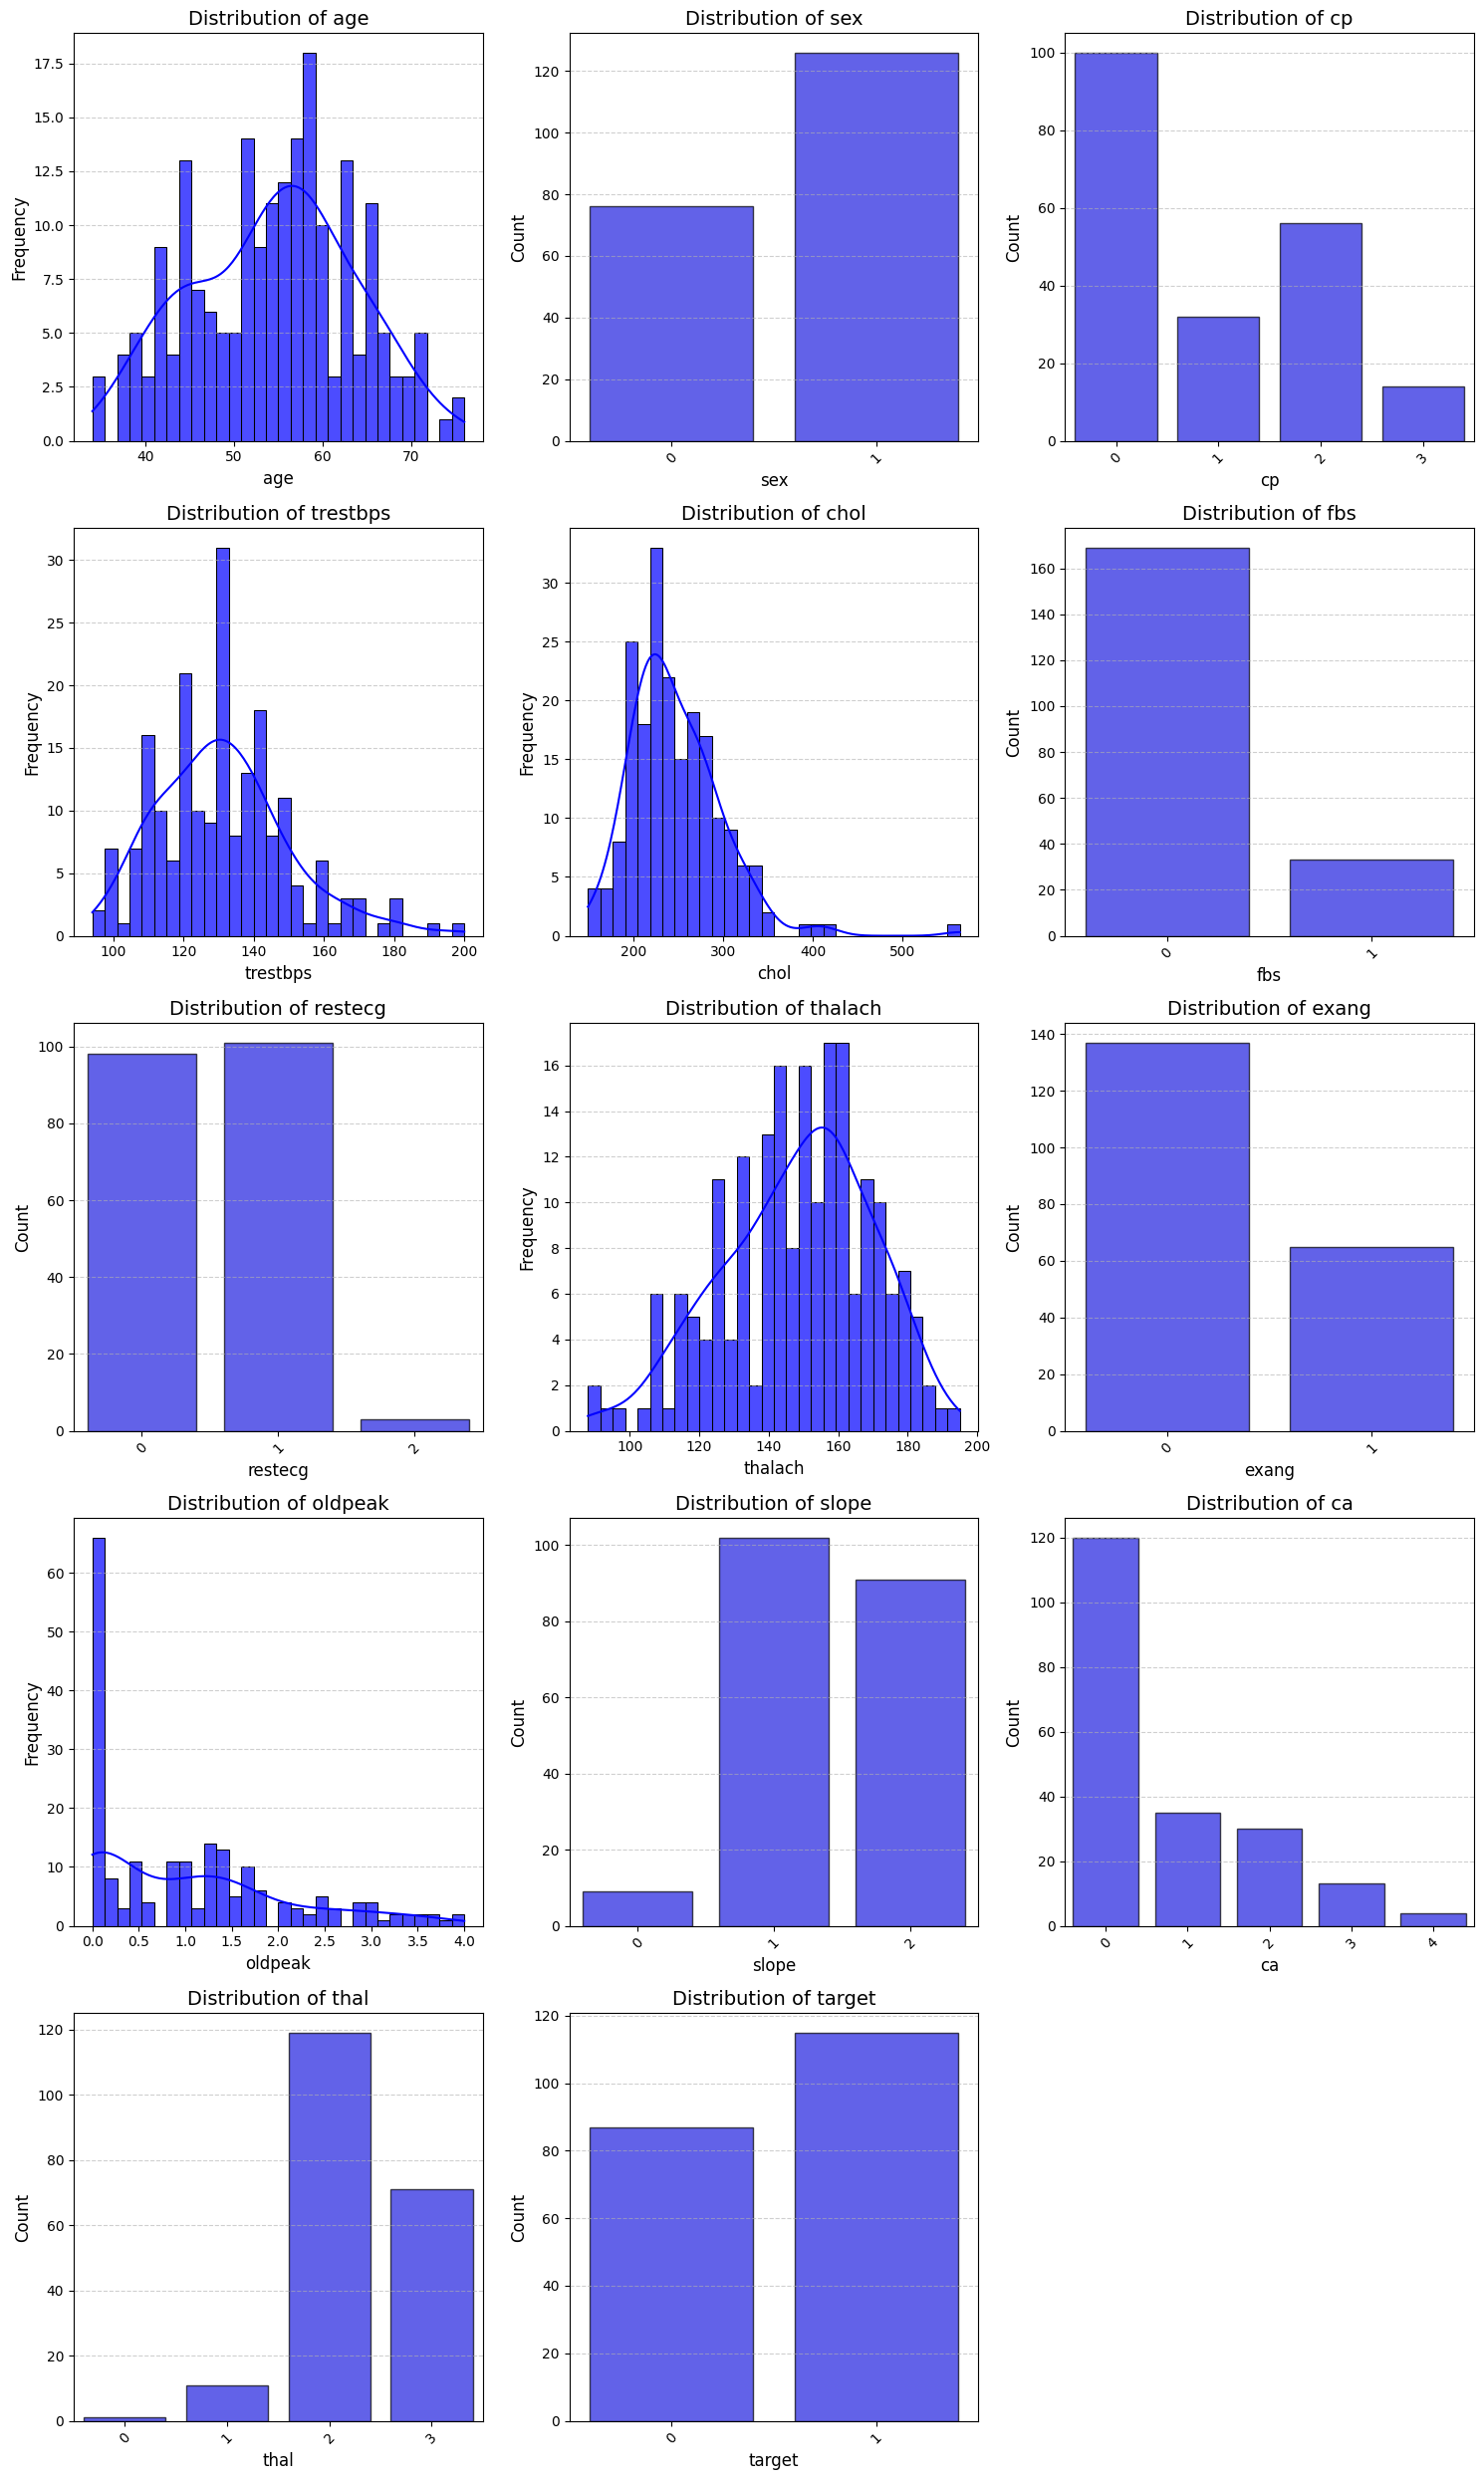

In [11]:
plot_counts(data)

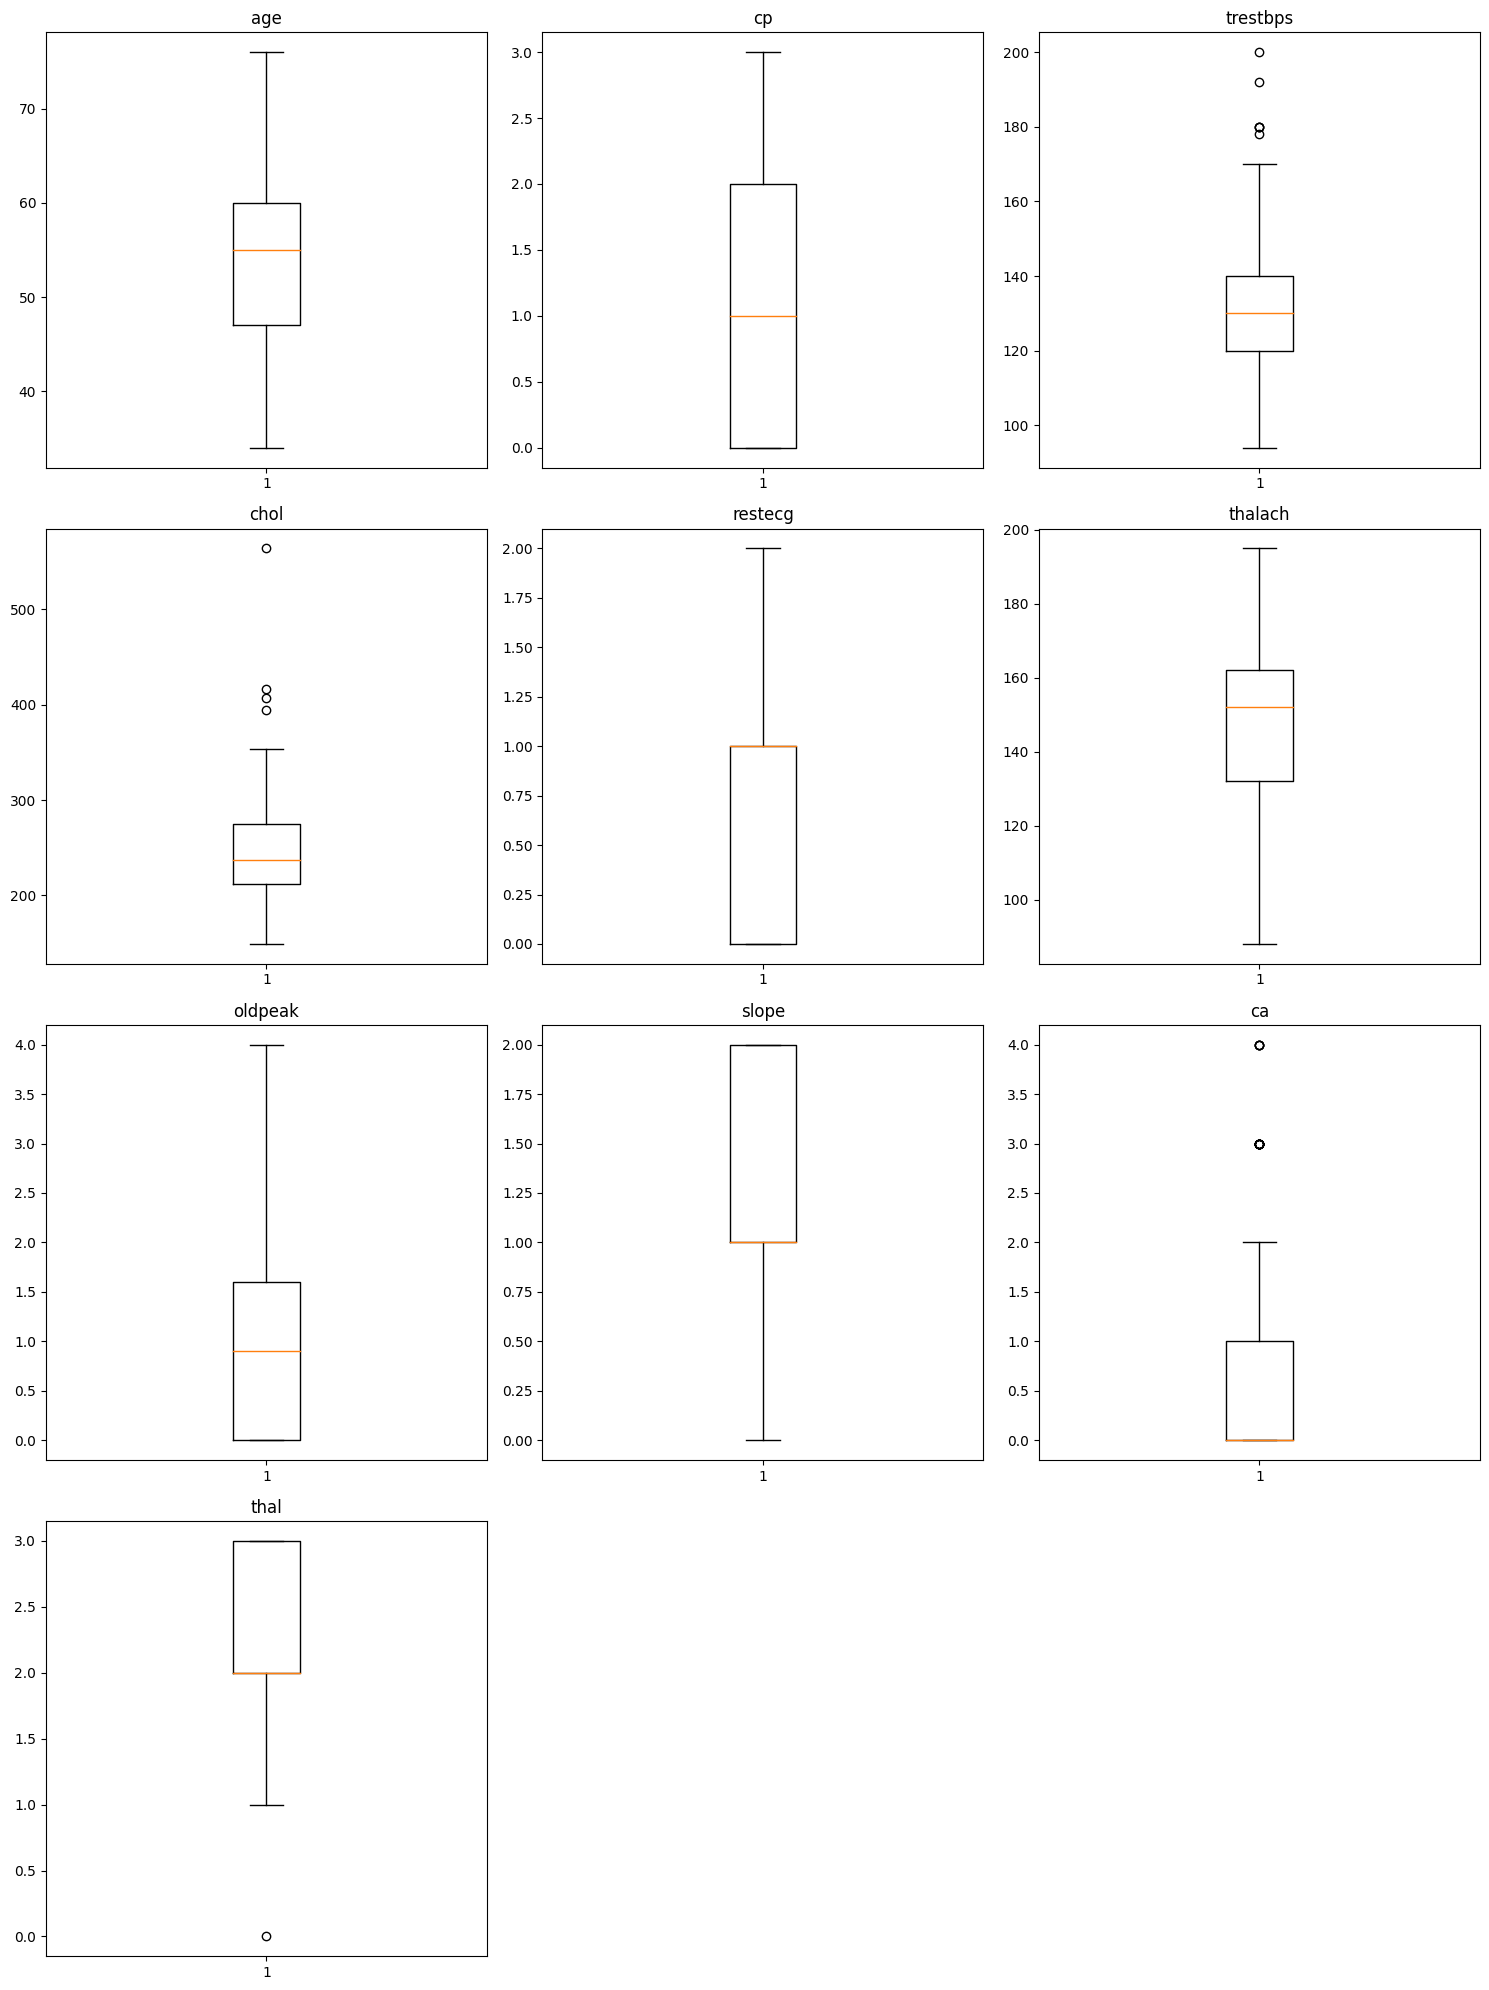

In [12]:
plot_box_plots(data)

In [15]:
feature_columns = [col for col in df.columns if col != target]

In [16]:
agg_stats = df.groupBy(target).agg(*[F.avg(col).alias(f"avg_{col}") for col in feature_columns])
agg_stats_pd = agg_stats.toPandas()
agg_stats_pd

target    avg_age   avg_sex    avg_cp  avg_trestbps    avg_chol   avg_fbs  \
0       1  52.408745  0.570342  1.378327    129.245247  240.979087  0.134981   
1       0  56.569138  0.827655  0.482966    134.106212  251.292585  0.164329   

   avg_restecg  avg_thalach  avg_exang  avg_oldpeak  avg_slope    avg_ca  \
0     0.598859   158.585551   0.134981     0.569962   1.593156  0.370722   
1     0.456914   139.130261   0.549098     1.600200   1.166333  1.158317   

   avg_thal  
0  2.119772  
1  2.539078

In [18]:
X = df.drop(target)
y = df.select(target)

In [19]:
def plot_corr(X_corr_with_target):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=X_corr_with_target.index, y=X_corr_with_target.values, palette='coolwarm', hue=X_corr_with_target.index)
    plt.title('Correlación de las columnas con target')
    plt.xticks(rotation=90)
    plt.ylabel('Correlación')
    plt.show()

In [20]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vectorized = assembler.transform(df)

correlations = []

for feature in feature_columns:
    corr = df_vectorized.stat.corr(feature, target)
    correlations.append((feature, corr))

X_corr_with_target = pd.Series(dict(correlations))

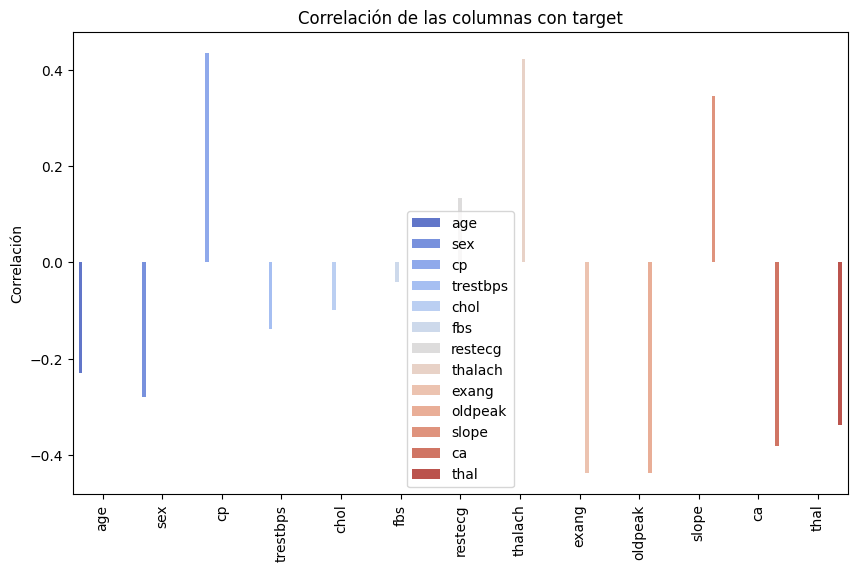

In [21]:
plot_corr(X_corr_with_target)

In [112]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=random_seed)

In [113]:
def remove_nans(df, threshold=0.1):
    total_rows = df.count()
    
    for col_name in df.columns:
        non_null_count = df.filter(F.col(col_name).isNotNull()).count()
        nan_count = total_rows - non_null_count
        nan_threshold = threshold * total_rows
        
        if nan_count > nan_threshold:
            mean_value = df.select(F.mean(F.col(col_name))).collect()[0][0]
            df = df.fillna({col_name: mean_value})
        else:
            df = df.dropna(subset=[col_name])
    
    return df

In [114]:
train_df = remove_nans(train_df)
test_df = remove_nans(test_df)

In [115]:
train_df.limit(5).toPandas()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   29    1   1       130   204    0        0      202      0      0.0      2   
1   29    1   1       130   204    0        0      202      0      0.0      2   
2   29    1   1       130   204    0        0      202      0      0.0      2   
3   34    0   1       118   210    0        1      192      0      0.7      2   
4   34    0   1       118   210    0        1      192      0      0.7      2   

   ca  thal  target  
0   0     2       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

In [116]:
def remove_outliers_zscore(df, col, threshold=3):
    mean = df.select(F.mean(col)).collect()[0][0]
    std = df.select(F.stddev(col)).collect()[0][0]
    
    return df.filter(F.abs(F.col(col) - mean) <= threshold * std)

In [117]:
def remove_outliers_tukey(df, col, threshold=1.5):
    
    q1 = df.approxQuantile(col, [0.25], 0)[0]
    q3 = df.approxQuantile(col, [0.75], 0)[0]
    
    iqr = q3 - q1
    
    lb = q1 - threshold * iqr
    ub = q3 + threshold * iqr
    
    return df.filter((F.col(col) >= lb) & (F.col(col) <= ub))

In [118]:
zscore_cols = ['age', 'chol', 'trestbps', 'thalach']

In [119]:
for col in train_df.columns:
    
    if train_df.select(col).distinct().count() == 2:
        continue
        
    if col in zscore_cols:
        train_df = remove_outliers_zscore(train_df, col)
    else:
        train_df = remove_outliers_tukey(train_df, col)

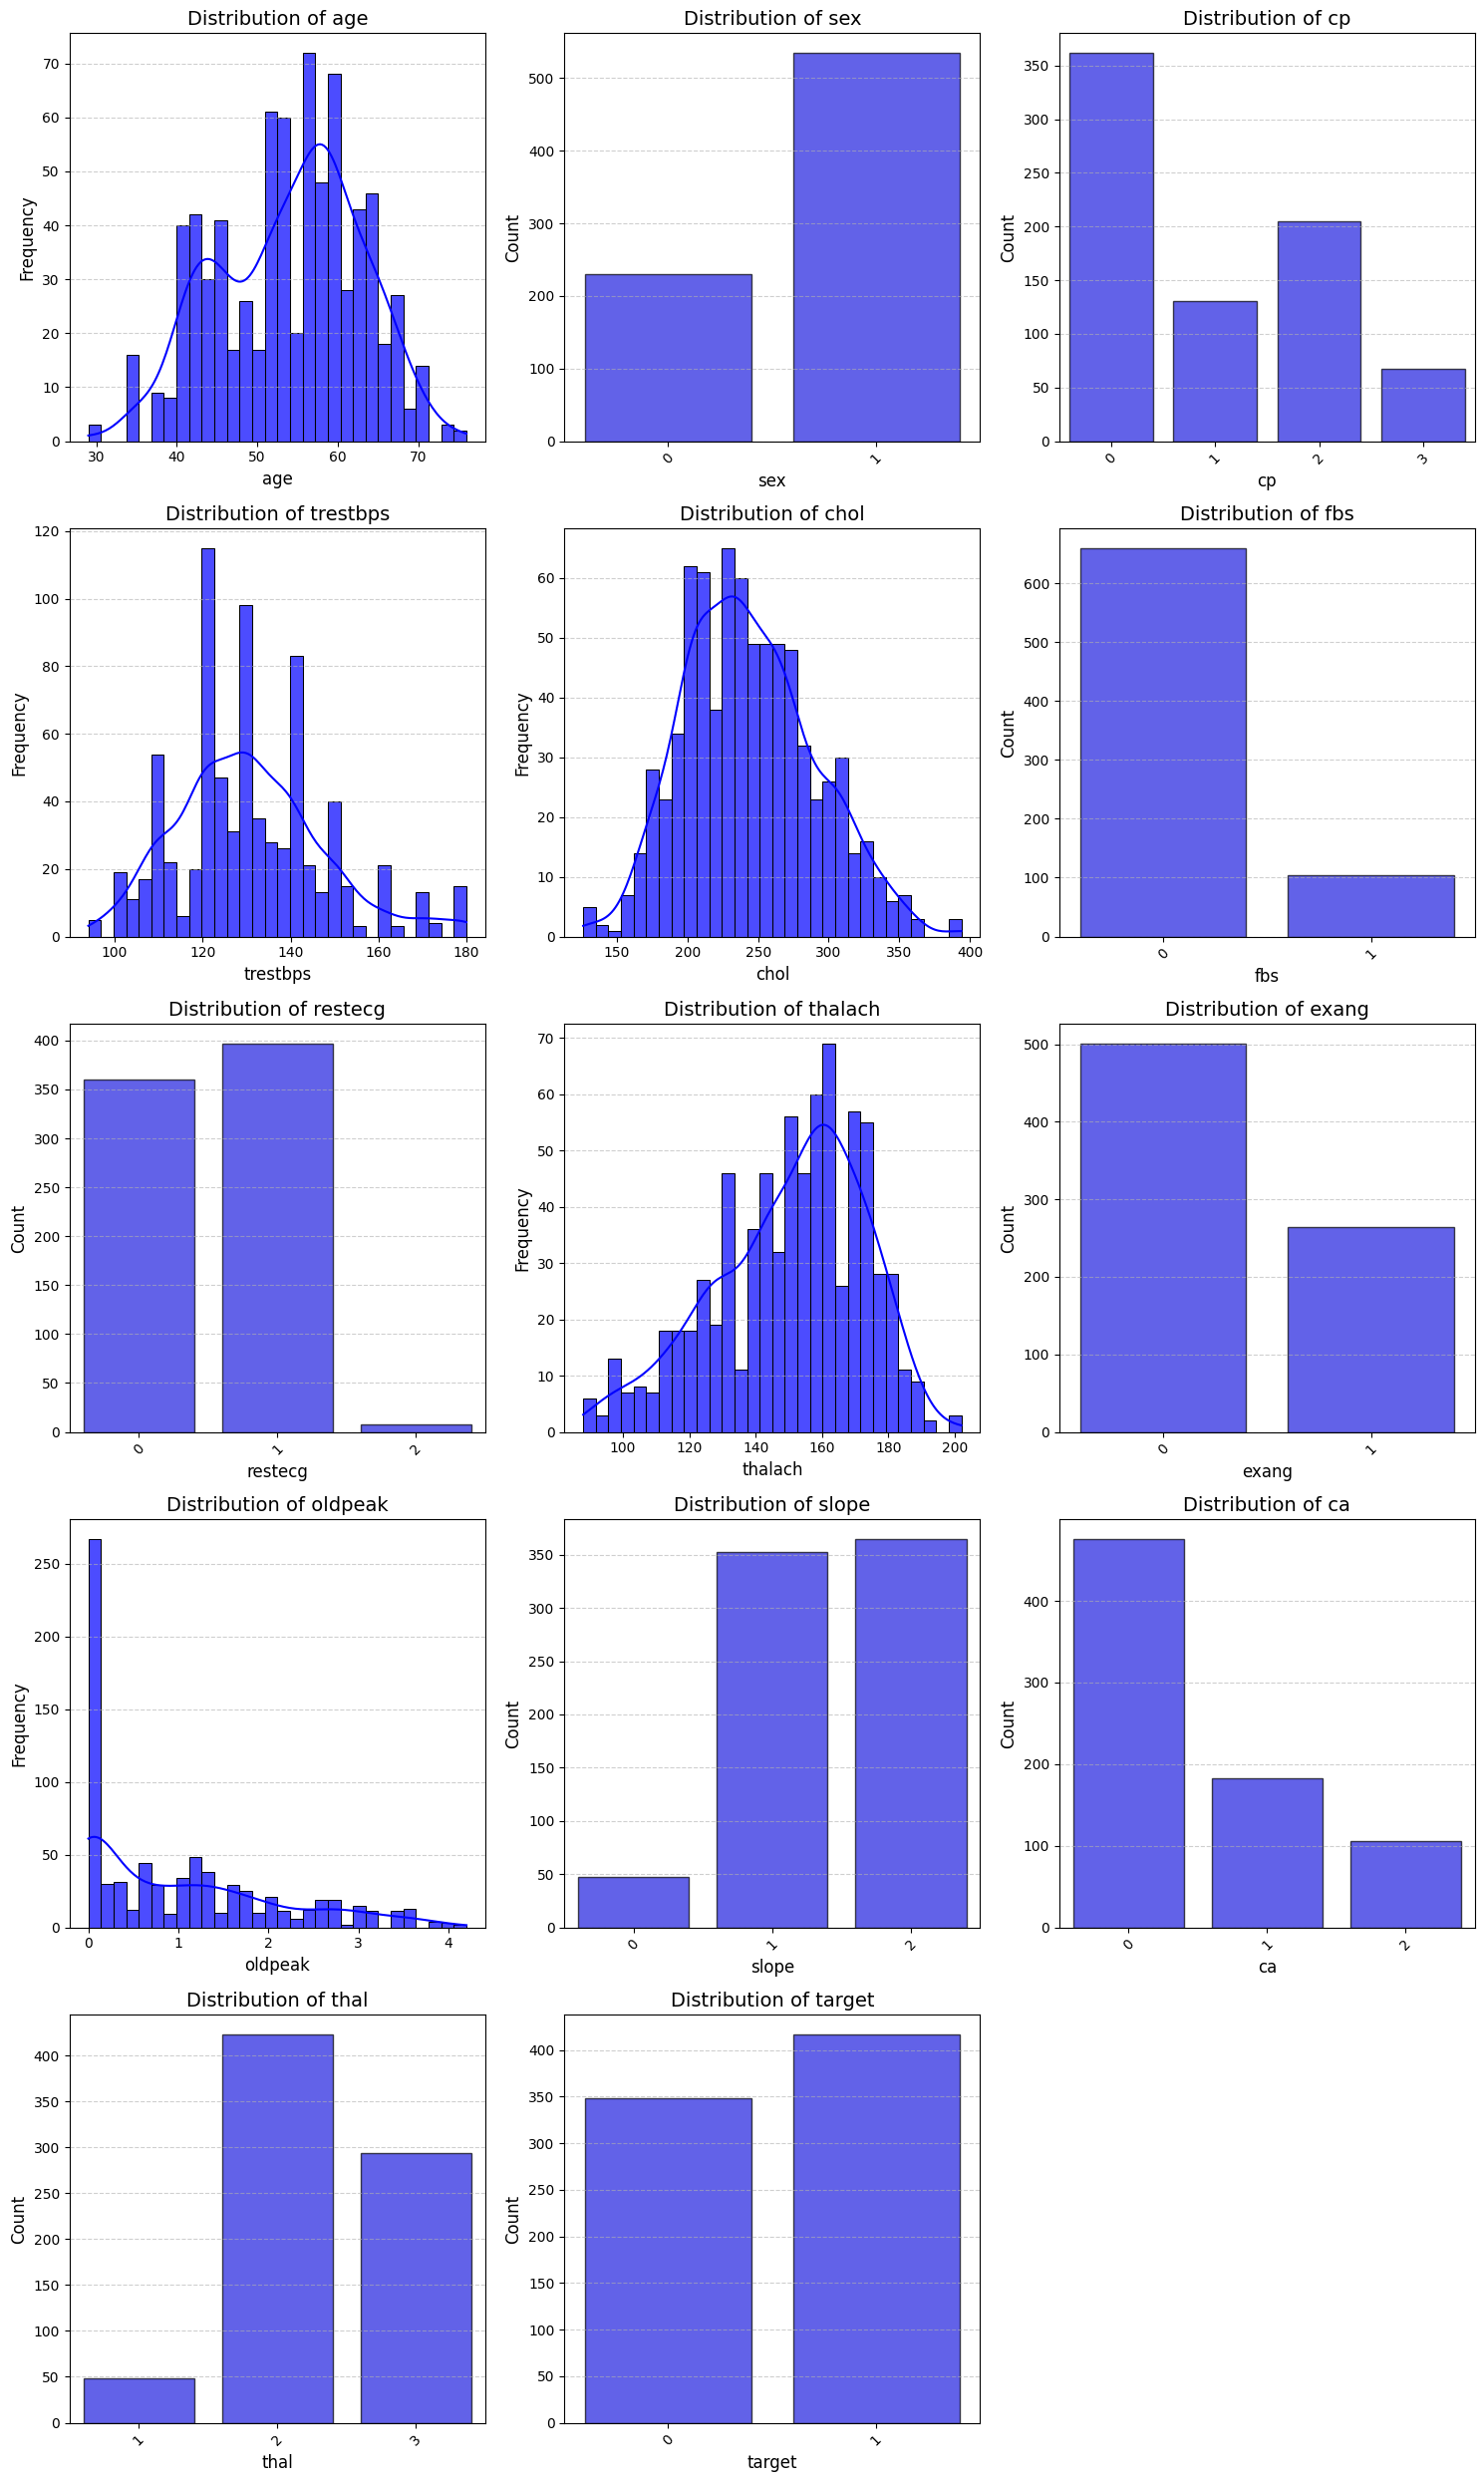

In [120]:
plot_counts(train_df.toPandas())

In [121]:
cat_cols = []
for col in train_df.columns:
    if train_df.select(col).distinct().count() < 10 and col != target:
        cat_cols.append(col)
cat_cols

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [122]:
feature_cols = [col for col in train_df.columns if col not in cat_cols and col != target]
feature_cols

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [125]:
for col in cat_cols:
    encoder = OneHotEncoder(inputCol=col, outputCol=col + '_onehot', handleInvalid='keep')
    encoder_model = encoder.fit(train_df)
    
    train_df = encoder_model.transform(train_df)
    test_df = encoder_model.transform(test_df)

train_df = train_df.drop(*cat_cols)
test_df = test_df.drop(*cat_cols)

train_df.limit(5).toPandas()

age  trestbps  chol  thalach  oldpeak  target  sex_onehot  \
0   29       130   204      202      0.0       1  (0.0, 1.0)   
1   29       130   204      202      0.0       1  (0.0, 1.0)   
2   29       130   204      202      0.0       1  (0.0, 1.0)   
3   34       118   210      192      0.7       1  (1.0, 0.0)   
4   34       118   210      192      0.7       1  (1.0, 0.0)   

              cp_onehot  fbs_onehot   restecg_onehot exang_onehot  \
0  (0.0, 1.0, 0.0, 0.0)  (1.0, 0.0)  (1.0, 0.0, 0.0)   (1.0, 0.0)   
1  (0.0, 1.0, 0.0, 0.0)  (1.0, 0.0)  (1.0, 0.0, 0.0)   (1.0, 0.0)   
2  (0.0, 1.0, 0.0, 0.0)  (1.0, 0.0)  (1.0, 0.0, 0.0)   (1.0, 0.0)   
3  (0.0, 1.0, 0.0, 0.0)  (1.0, 0.0)  (0.0, 1.0, 0.0)   (1.0, 0.0)   
4  (0.0, 1.0, 0.0, 0.0)  (1.0, 0.0)  (0.0, 1.0, 0.0)   (1.0, 0.0)   

      slope_onehot        ca_onehot           thal_onehot  
0  (0.0, 0.0, 1.0)  (1.0, 0.0, 0.0)  (0.0, 0.0, 1.0, 0.0)  
1  (0.0, 0.0, 1.0)  (1.0, 0.0, 0.0)  (0.0, 0.0, 1.0, 0.0)  
2  (0.0, 0.0, 1.0)  (1.0, 0.0, 0.0)  (0.0, 0.0, 1.0, 0.0)  
3  (0.0, 0.0, 1.0)  (1.0, 0.0, 0.0)  (0.0, 0.0, 1.0, 0.0)  
4  (0.0, 0.0, 1.0)  (1.0, 0.0, 0.0)  (0.0, 0.0, 1.0, 0.0)

In [126]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

pipeline = Pipeline(stages=[assembler, scaler])
pipeline_model = pipeline.fit(train_df)

train_df_scaled = pipeline_model.transform(train_df)
test_df_scaled = pipeline_model.transform(test_df)

train_df_scaled = train_df_scaled.drop(*feature_cols)
test_df_scaled = test_df_scaled.drop(*feature_cols)

train_df_scaled = train_df_scaled.drop('features')
test_df_scaled = test_df_scaled.drop('features')

train_df_scaled.limit(5).toPandas()

target  sex_onehot             cp_onehot  fbs_onehot   restecg_onehot  \
0       1  (0.0, 1.0)  (0.0, 1.0, 0.0, 0.0)  (1.0, 0.0)  (1.0, 0.0, 0.0)   
1       1  (0.0, 1.0)  (0.0, 1.0, 0.0, 0.0)  (1.0, 0.0)  (1.0, 0.0, 0.0)   
2       1  (0.0, 1.0)  (0.0, 1.0, 0.0, 0.0)  (1.0, 0.0)  (1.0, 0.0, 0.0)   
3       1  (1.0, 0.0)  (0.0, 1.0, 0.0, 0.0)  (1.0, 0.0)  (0.0, 1.0, 0.0)   
4       1  (1.0, 0.0)  (0.0, 1.0, 0.0, 0.0)  (1.0, 0.0)  (0.0, 1.0, 0.0)   

  exang_onehot     slope_onehot        ca_onehot           thal_onehot  \
0   (1.0, 0.0)  (0.0, 0.0, 1.0)  (1.0, 0.0, 0.0)  (0.0, 0.0, 1.0, 0.0)   
1   (1.0, 0.0)  (0.0, 0.0, 1.0)  (1.0, 0.0, 0.0)  (0.0, 0.0, 1.0, 0.0)   
2   (1.0, 0.0)  (0.0, 0.0, 1.0)  (1.0, 0.0, 0.0)  (0.0, 0.0, 1.0, 0.0)   
3   (1.0, 0.0)  (0.0, 0.0, 1.0)  (1.0, 0.0, 0.0)  (0.0, 0.0, 1.0, 0.0)   
4   (1.0, 0.0)  (0.0, 0.0, 1.0)  (1.0, 0.0, 0.0)  (0.0, 0.0, 1.0, 0.0)   

                                     scaled_features  
0  [-2.8088030056166353, -0.04020946832853511, -0...  
1  [-2.8088030056166353, -0.04020946832853511, -0...  
2  [-2.8088030056166353, -0.04020946832853511, -0...  
3  [-2.2467191144120924, -0.7541802986109002, -0....  
4  [-2.2467191144120924, -0.7541802986109002, -0....

In [127]:
all_cols = [col for col in train_df_scaled.columns if col != target]

In [128]:
assembler = VectorAssembler(inputCols=all_cols, outputCol="features")

In [129]:
train_df_final = assembler.transform(train_df_scaled)
test_df_final = assembler.transform(test_df_scaled)

train_df_final = train_df_final.drop(*all_cols)
test_df_final = test_df_final.drop(*all_cols)

In [130]:
train_df_final.limit(5).toPandas()

target                                           features
0       1  (0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...
1       1  (0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...
2       1  (0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...
3       1  (1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
4       1  (1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...

### Model

In [164]:
def get_second_value(probability):
    if isinstance(probability, DenseVector):
        return float(probability.values[1])
    return None

In [273]:
def get_stats(model_name, _predictions, threshold):

    get_second_value_udf = F.udf(get_second_value, DoubleType())
    
    _predictions = _predictions.withColumn(
        "prediction",
        F.when(get_second_value_udf(F.col("probability")) > threshold, 1.0).otherwise(0.0)
    )
    
    evaluator = BinaryClassificationEvaluator(labelCol="target")
    auc = evaluator.evaluate(_predictions)
    
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
    accuracy = accuracy_evaluator.evaluate(_predictions)

    precision_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="weightedPrecision")
    precision = precision_evaluator.evaluate(_predictions)

    recall_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="weightedRecall")
    recall = recall_evaluator.evaluate(_predictions)

    f1_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="f1")
    f1_score = f1_evaluator.evaluate(_predictions)

    false_neg = _predictions.filter((F.col('prediction') == 0) & (F.col('target') == 1)).count()
    false_pos = _predictions.filter((F.col('prediction') == 1) & (F.col('target') == 0)).count()

    total_count = _predictions.count()

    false_neg_percentage = (false_neg / total_count) * 100
    false_pos_percentage = (false_pos / total_count) * 100

    confusion_matrix = _predictions.groupBy("target", "prediction").count().toPandas()

    return {
        'AUC': [auc],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1_score],
        '% False Positives': [false_pos_percentage],
        '% False Negatives': [false_neg_percentage],
        'Threshold': threshold
    }, confusion_matrix

In [285]:
def show_cm(model_name, cm, ax):
    cm_pivot = cm.pivot(index='target', columns='prediction', values='count')
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm_pivot, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

In [262]:
models = {
    'Logistic Regression': LogisticRegression(labelCol="target", featuresCol="features"),
    'Decision Tree': DecisionTreeClassifier(labelCol="target", featuresCol="features"),
    'Random Forest': RandomForestClassifier(labelCol="target", featuresCol="features"),
    'Gradient-Boosted Trees': GBTClassifier(labelCol="target", featuresCol="features")
}

In [263]:
fitted_models = {}
predictions = {}

for name, model in models.items():
    print(name)
    fitted_model = model.fit(train_df_final)
    fitted_models[name] = fitted_model
    predictions[name] = fitted_model.transform(test_df_final)

Logistic Regression
Decision Tree
Random Forest
Gradient-Boosted Trees


In [287]:
stats = {}
conf_matrices = {}

for name, pred in predictions.items():
    stats[name],  conf_matrices[name] = get_stats(name, pred, 0.5)

pd.DataFrame(stats)

Logistic Regression         Decision Tree  \
AUC                [0.9401239785855164]  [0.9027190757959989]   
Accuracy           [0.8579881656804734]  [0.8520710059171598]   
Precision          [0.8643054476387809]  [0.8529202279202279]   
Recall             [0.8579881656804733]  [0.8520710059171598]   
F1 Score           [0.8581373795719551]   [0.852226934023076]   
% False Positives  [10.059171597633137]   [8.284023668639055]   
% False Negatives   [4.142011834319527]   [6.508875739644971]   
Threshold                           0.5                   0.5   

                          Random Forest Gradient-Boosted Trees  
AUC                [0.9622428853198085]   [0.9611158072696535]  
Accuracy           [0.8994082840236687]   [0.9526627218934911]  
Precision          [0.9047680662483017]   [0.9552036199095022]  
Recall             [0.8994082840236687]   [0.9526627218934911]  
F1 Score            [0.899535146933991]   [0.9527324527324528]  
% False Positives  [7.6923076923076925]    [4.142011834319527]  
% False Negatives   [2.366863905325444]    [0.591715976331361]  
Threshold                           0.5                    0.5

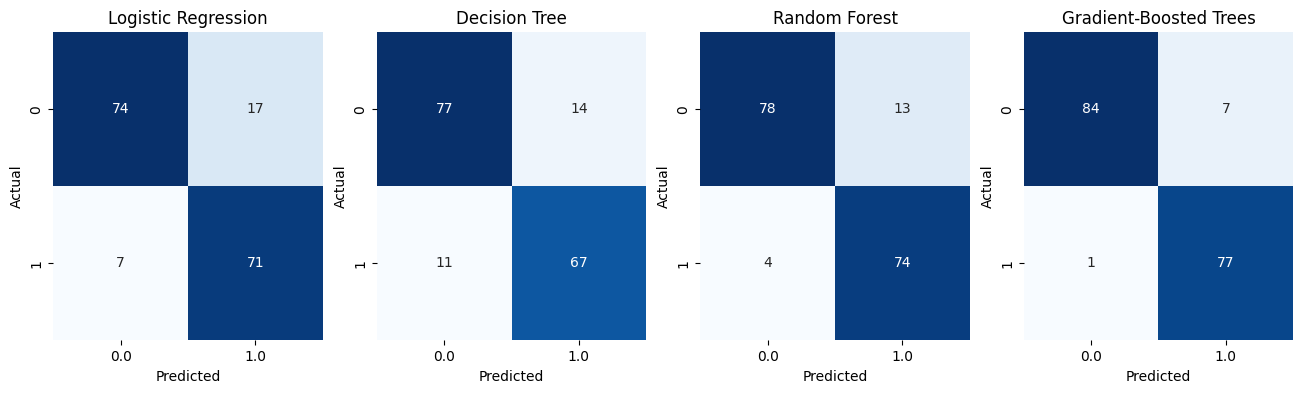

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [288]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, (name, cm) in enumerate(conf_matrices.items()):
    show_cm(name, cm, axes[i])

plt.tight_layout()
plt.show()

In [ ]:
thresh_res = {}

for name, pred in predictions.items():
    thresh_res[name] = []
    for thresh in np.arange(0, 1.1, 0.1):
        stat, _ = get_stats(name, pred, thresh)
        thresh_res[name].append(stat)

In [302]:
for name, model in zip(predictions.keys(), thresh_res):
    print(name)
    display(pd.DataFrame(thresh_res[model]))

Logistic Regression


AUC               Accuracy              Precision  \
0   [0.9401239785855164]  [0.46153846153846156]  [0.21301775147928995]   
1   [0.9401239785855164]    [0.727810650887574]   [0.8183037750529902]   
2   [0.9401239785855164]   [0.7988165680473372]   [0.8393807450411224]   
3   [0.9401239785855164]   [0.8224852071005917]   [0.8487848383500558]   
4   [0.9401239785855164]   [0.8579881656804734]   [0.8697172392824567]   
5   [0.9401239785855164]   [0.8579881656804734]   [0.8643054476387809]   
6   [0.9401239785855164]   [0.8816568047337278]   [0.8816568047337279]   
7   [0.9401239785855164]   [0.8579881656804734]   [0.8602286602286602]   
8   [0.9401239785855164]    [0.863905325443787]   [0.8741792798396573]   
9   [0.9401239785855164]   [0.7869822485207101]   [0.8243006993006994]   
10  [0.9401239785855164]   [0.5384615384615384]  [0.28994082840236685]   

                   Recall              F1 Score     % False Positives  \
0   [0.46153846153846156]   [0.291497975708502]   [53.84615384615385]   
1    [0.7278106508875739]  [0.7143589743589744]  [26.627218934911244]   
2    [0.7988165680473372]  [0.7958346001824264]   [18.34319526627219]   
3    [0.8224852071005917]  [0.8212510803802938]  [15.384615384615385]   
4    [0.8579881656804733]  [0.8579185520361992]  [11.242603550295858]   
5    [0.8579881656804733]  [0.8581373795719551]  [10.059171597633137]   
6    [0.8816568047337279]  [0.8816568047337279]  [5.9171597633136095]   
7    [0.8579881656804733]  [0.8571397308239413]   [4.733727810650888]   
8     [0.863905325443787]  [0.8618475163458423]   [2.366863905325444]   
9    [0.7869822485207101]  [0.7766950031100975]  [1.7751479289940828]   
10   [0.5384615384615384]  [0.3769230769230769]                 [0.0]   

       % False Negatives  Threshold  
0                  [0.0]        0.0  
1    [0.591715976331361]        0.1  
2   [1.7751479289940828]        0.2  
3    [2.366863905325444]        0.3  
4   [2.9585798816568047]        0.4  
5    [4.142011834319527]        0.5  
6   [5.9171597633136095]        0.6  
7    [9.467455621301776]        0.7  
8   [11.242603550295858]        0.8  
9   [19.526627218934912]        0.9  
10   [46.15384615384615]        1.0

Decision Tree


AUC              Accuracy              Precision  \
0   [0.9027190757959989]  [0.7869822485207101]    [0.854251012145749]   
1   [0.9027190757959989]  [0.8165680473372781]   [0.8619118295030264]   
2   [0.9027190757959989]   [0.834319526627219]   [0.8612040133779264]   
3   [0.9027190757959989]   [0.834319526627219]   [0.8612040133779264]   
4   [0.9027190757959989]  [0.8520710059171598]   [0.8529202279202279]   
5   [0.9027190757959989]  [0.8520710059171598]   [0.8529202279202279]   
6   [0.9027190757959989]  [0.8520710059171598]   [0.8529202279202279]   
7   [0.9027190757959989]  [0.8520710059171598]   [0.8529202279202279]   
8   [0.9027190757959989]  [0.8402366863905325]   [0.8401381227468185]   
9   [0.9027190757959989]  [0.8402366863905325]   [0.8401381227468185]   
10  [0.9027190757959989]  [0.5384615384615384]  [0.28994082840236685]   

                  Recall              F1 Score     % False Positives  \
0   [0.7869822485207101]  [0.7806902002107481]  [21.301775147928996]   
1   [0.8165680473372781]  [0.8135610723846018]   [17.75147928994083]   
2    [0.834319526627219]  [0.8331676750216077]  [14.792899408284024]   
3    [0.834319526627219]  [0.8331676750216077]  [14.792899408284024]   
4   [0.8520710059171598]   [0.852226934023076]   [8.284023668639055]   
5   [0.8520710059171598]   [0.852226934023076]   [8.284023668639055]   
6   [0.8520710059171598]   [0.852226934023076]   [8.284023668639055]   
7   [0.8520710059171598]   [0.852226934023076]   [8.284023668639055]   
8   [0.8402366863905326]  [0.8401578326485781]  [7.6923076923076925]   
9   [0.8402366863905326]  [0.8401578326485781]  [7.6923076923076925]   
10  [0.5384615384615384]  [0.3769230769230769]                 [0.0]   

       % False Negatives  Threshold  
0                  [0.0]        0.0  
1    [0.591715976331361]        0.1  
2   [1.7751479289940828]        0.2  
3   [1.7751479289940828]        0.3  
4    [6.508875739644971]        0.4  
5    [6.508875739644971]        0.5  
6    [6.508875739644971]        0.6  
7    [6.508875739644971]        0.7  
8    [8.284023668639055]        0.8  
9    [8.284023668639055]        0.9  
10   [46.15384615384615]        1.0

Random Forest


AUC               Accuracy              Precision  \
0   [0.9622428853198085]  [0.46153846153846156]  [0.21301775147928995]   
1   [0.9622428853198085]    [0.650887573964497]   [0.8012352610892757]   
2   [0.9622428853198085]   [0.7514792899408284]   [0.8290768719482577]   
3   [0.9622428853198085]   [0.7988165680473372]   [0.8455933865769931]   
4   [0.9622428853198085]   [0.8284023668639053]   [0.8574324627032839]   
5   [0.9622428853198085]   [0.8994082840236687]   [0.9047680662483017]   
6   [0.9622428853198085]    [0.893491124260355]   [0.8934911242603549]   
7   [0.9622428853198085]   [0.8875739644970414]   [0.8884351949420443]   
8   [0.9622428853198085]   [0.8520710059171598]   [0.8732287449392713]   
9   [0.9622428853198085]   [0.7159763313609467]   [0.8140564471499724]   
10  [0.9622428853198085]   [0.5384615384615384]  [0.28994082840236685]   

                   Recall              F1 Score     % False Positives  \
0   [0.46153846153846156]   [0.291497975708502]   [53.84615384615385]   
1     [0.650887573964497]  [0.6150588303736346]    [34.9112426035503]   
2    [0.7514792899408285]  [0.7418356291595728]    [24.2603550295858]   
3    [0.7988165680473374]  [0.7951874102128773]   [18.93491124260355]   
4    [0.8284023668639053]   [0.827015646241956]  [15.384615384615385]   
5    [0.8994082840236687]   [0.899535146933991]  [7.6923076923076925]   
6    [0.8934911242603549]  [0.8934911242603549]   [5.325443786982249]   
7    [0.8875739644970414]  [0.8872156281583627]   [4.142011834319527]   
8    [0.8520710059171599]  [0.8482169171824344]   [1.183431952662722]   
9    [0.7159763313609467]  [0.6824972129319957]                 [0.0]   
10   [0.5384615384615384]  [0.3769230769230769]                 [0.0]   

       % False Negatives  Threshold  
0                  [0.0]        0.0  
1                  [0.0]        0.1  
2    [0.591715976331361]        0.2  
3    [1.183431952662722]        0.3  
4   [1.7751479289940828]        0.4  
5    [2.366863905325444]        0.5  
6    [5.325443786982249]        0.6  
7    [7.100591715976331]        0.7  
8   [13.609467455621301]        0.8  
9   [28.402366863905325]        0.9  
10   [46.15384615384615]        1.0

Gradient-Boosted Trees


AUC               Accuracy              Precision  \
0   [0.9611158072696535]  [0.46153846153846156]  [0.21301775147928995]   
1   [0.9611158072696535]   [0.8461538461538461]   [0.8788410886742756]   
2   [0.9611158072696535]   [0.9230769230769231]   [0.9310393258426966]   
3   [0.9611158072696535]   [0.9467455621301775]   [0.9501508295625942]   
4   [0.9611158072696535]   [0.9526627218934911]   [0.9552036199095022]   
5   [0.9611158072696535]   [0.9526627218934911]   [0.9552036199095022]   
6   [0.9611158072696535]   [0.9349112426035503]   [0.9356384356384357]   
7   [0.9611158072696535]   [0.9349112426035503]   [0.9356384356384357]   
8   [0.9611158072696535]   [0.9230769230769231]   [0.9232067510548523]   
9   [0.9611158072696535]   [0.8579881656804734]   [0.8618565476457147]   
10  [0.9611158072696535]   [0.5384615384615384]  [0.28994082840236685]   

                   Recall              F1 Score     % False Positives  \
0   [0.46153846153846156]   [0.291497975708502]   [53.84615384615385]   
1    [0.8461538461538461]  [0.8447257383966245]  [14.792899408284024]   
2    [0.9230769230769231]  [0.9231361837728054]   [7.100591715976331]   
3    [0.9467455621301775]    [0.94682397357244]   [4.733727810650888]   
4    [0.9526627218934911]  [0.9527324527324528]   [4.142011834319527]   
5    [0.9526627218934911]  [0.9527324527324528]   [4.142011834319527]   
6    [0.9349112426035503]  [0.9349798509701537]   [4.142011834319527]   
7    [0.9349112426035503]  [0.9349798509701537]   [4.142011834319527]   
8    [0.9230769230769231]  [0.9231094063412747]   [4.142011834319527]   
9    [0.8579881656804733]  [0.8568229715489988]   [4.142011834319527]   
10   [0.5384615384615384]  [0.3769230769230769]                 [0.0]   

       % False Negatives  Threshold  
0                  [0.0]        0.0  
1    [0.591715976331361]        0.1  
2    [0.591715976331361]        0.2  
3    [0.591715976331361]        0.3  
4    [0.591715976331361]        0.4  
5    [0.591715976331361]        0.5  
6    [2.366863905325444]        0.6  
7    [2.366863905325444]        0.7  
8   [3.5502958579881656]        0.8  
9   [10.059171597633137]        0.9  
10   [46.15384615384615]        1.0

Best is GBT at 0.4-0.5